In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
from scipy import stats #for streamgraph
import seaborn as sns
import matplotlib.patches as patches
import pickle
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.path import Path
from matplotlib.patheffects import withStroke
from matplotlib.text import TextPath
from matplotlib.transforms import Affine2D

from datetime import date, datetime

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('./strava/activities.csv')

In [3]:
# Convert "Activity Date" to datetime type
df["Activity Date"] = pd.to_datetime(df["Activity Date"])

# Add a new column "ISOyear"
df["ISOyear"] = df["Activity Date"].dt.isocalendar()["year"]
df["ISOweek"] = df["Activity Date"].dt.isocalendar()["week"]

In [4]:
#get weeks commencing
weeks = df[["ISOyear", "ISOweek"]].drop_duplicates().reset_index(drop=True)

week_commencing = []

for i in range(len(weeks)):
    x = pd.to_datetime(date.fromisocalendar(weeks["ISOyear"][i],weeks["ISOweek"][i],1))
    week_commencing.append(x)
    
weeks["week_commencing"] = week_commencing

#merge back to dataframe
df = pd.merge(df, weeks, left_on=["ISOyear", "ISOweek"], right_on=["ISOyear", "ISOweek"], how='left')

#get month based on weeks commencing
df["month"] = df["week_commencing"].dt.month
df.loc[df["week_commencing"] =="2023-01-01", "month"] = 'January'

In [5]:
df = df[(df['week_commencing'] >= "2023-01-01")]
df = df[(df['Activity Type'] == 'Run')]

In [6]:
df = df[['Activity Date','Activity Type','Distance','ISOyear','ISOweek','week_commencing','month']]
df

,Activity Date,Activity Type,Distance,ISOyear,ISOweek,week_commencing,month
770,2023-01-03 19:13:19,Run,12.63,2023,1,2023-01-02,1
771,2023-01-04 17:02:32,Run,6.18,2023,1,2023-01-02,1
772,2023-01-05 17:09:42,Run,1.56,2023,1,2023-01-02,1
773,2023-01-05 17:58:37,Run,16.59,2023,1,2023-01-02,1
774,2023-01-06 07:31:46,Run,2.85,2023,1,2023-01-02,1
...,...,...,...,...,...,...,...
1043,2023-12-19 19:16:10,Run,14.48,2023,51,2023-12-18,12
1044,2023-12-21 18:38:53,Run,12.25,2023,51,2023-12-18,12
1045,2023-12-24 09:22:50,Run,42.17,2023,51,2023-12-18,12
1046,2023-12-26 10:41:50,Run,42.18,2023,52,2023-12-25,12


In [7]:
# Extract the month and day from the 'Activity Date' column
df['month'] = pd.to_datetime(df['Activity Date']).dt.month_name()
df['day'] = pd.to_datetime(df['Activity Date']).dt.day

# Group by both month and day and sum the distances for each day
daily_sums = df.groupby(['month', 'day'])['Distance'].sum().reset_index(name='distance_sum')

# Pivot the table to have days as rows, months as columns, and the sum of distances as values
pivot_table = daily_sums.pivot(index='day', columns='month', values='distance_sum')

# If needed, fill any missing values in the resulting DataFrame
pivot_table = pivot_table.fillna(0)

# Reorder columns to match the desired format
desired_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November','December']
pivot_table = pivot_table[desired_order]


In [8]:
df = pivot_table.copy()

In [9]:
def map_to_color(value):
    if value <= 5:
        return 'blue'
    elif 5 < value <= 10:
        return 'orange'
    elif 10 < value <= 21:
        return 'red'
    elif 21 < value <= 42:
        return 'pink'
    else:
        return 'purple'

In [10]:
df['color'] = df['January'].apply(map_to_color)

In [11]:
months = ['April', 'March', 'February','January', 'December', 'November','October', 'September', 'August','July', 'June', 'May']

In [14]:
df

month,January,February,March,April,May,June,July,August,September,October,November,December,color
day,,,,,,,,,,,,,
1,0.00,0.00,0.00,9.72,0.00,9.27,0.00,14.13,19.97,24.78,0.00,0.00,blue
2,0.00,17.71,0.00,32.80,13.69,12.10,24.46,0.00,0.00,0.00,14.98,16.51,blue
3,12.63,0.00,16.22,0.00,7.43,7.24,0.00,19.87,27.36,14.16,0.00,24.23,red
4,6.18,11.26,0.00,13.32,0.00,22.41,11.53,5.84,0.00,9.66,8.05,13.97,orange
5,18.15,30.44,25.83,0.00,0.00,0.00,14.52,0.00,13.50,0.00,23.20,13.61,red
6,2.85,0.00,0.00,9.44,0.00,13.67,7.02,32.19,0.00,9.44,7.26,0.00,blue
7,0.00,12.60,0.00,9.50,22.69,0.00,0.00,0.00,0.00,0.00,14.29,0.00,blue
8,22.78,20.12,0.00,0.00,0.00,0.00,0.00,17.13,12.65,19.87,0.00,0.00,pink
9,0.00,0.00,0.00,25.79,14.12,0.00,21.91,0.00,4.25,0.00,5.06,21.38,blue


In [31]:
# def swarm_creator(month):
#     fig,ax = plt.subplots()
#     ax.set_xlim(0, 10)
#     swarm = sns.swarmplot(data=df, x=month, ax=ax, dodge=True)
#     plt.close()
#     return swarm

def swarm_creator(month, inner_radius=5, dodge_value=0.2):
    fig, ax = plt.subplots()

    # Set x-axis limit
    ax.set_xlim(0, 10)

    # Filter out rows where the data for the specified month is zero
    df_filtered = df[df[month] != 0].copy()

    # Adjust y-coordinates to start from the inner circle
    df_filtered[month] = df_filtered[month] + inner_radius

    # Create the swarm plot with dodge parameter
    swarm = sns.swarmplot(data=df_filtered, x=month, ax=ax, dodge=dodge_value)

    # Draw an inner circle
    inner_circle = plt.Circle((5, inner_radius), inner_radius, color='red', fill=False, linestyle='dashed', linewidth=2)
    ax.add_patch(inner_circle)

    plt.close()
    return swarm

def swarm_creator(month, inner_radius=5):
    fig, ax = plt.subplots()

    # Set x-axis limit
    ax.set_xlim(0, 10)

    # Filter out rows where the data for the specified month is zero
    df_filtered = df[df[month] != 0].copy()

    # Adjust y-coordinates to start from the inner circle
    df_filtered[month] = df_filtered[month] + inner_radius

    # Create the swarm plot
    swarm = sns.swarmplot(data=df_filtered, x=month, ax=ax, dodge=True)

    # Manually adjust x-coordinates for better centralization when there are only two points
    if len(df_filtered[month].unique()) == 2:
        for tick in ax.get_xticks():
            ax.plot([tick - 0.1, tick + 0.1], [inner_radius, inner_radius], color='black', linewidth=2)

    # Draw an inner circle
    inner_circle = plt.Circle((5, inner_radius), inner_radius, color='red', fill=False, linestyle='dashed', linewidth=2)
    ax.add_patch(inner_circle)

    plt.close()
    return swarm


def extract_raw_coordinates_from_swarm(swarm):
    x,y = np.array(swarm.collections[0].get_offsets()).T
    ##### Scale up y by some amount otherwise all points are too close and look ugly
    y = y*80
    return x, y

def add_offset(x,y):
    ##### We will add a constant offset to all the swarms before plotting
    constant_offset = np.array([1, 0])
    shifted_xy = np.column_stack([x,y]) + constant_offset
    return shifted_xy

def rotation(angle):
    ##### This matrix defines a counter-clockwise rotation by angle
    rotation_matrix = np.array(
        [
            [np.cos(angle), -np.sin(angle)],
            [np.sin(angle), np.cos(angle)]
        ]
    )
    return rotation_matrix

def apply_rotation(rotation_matrix, shifted_xy):
    rotated_xy = rotation_matrix.dot(shifted_xy.T)
    return rotated_xy

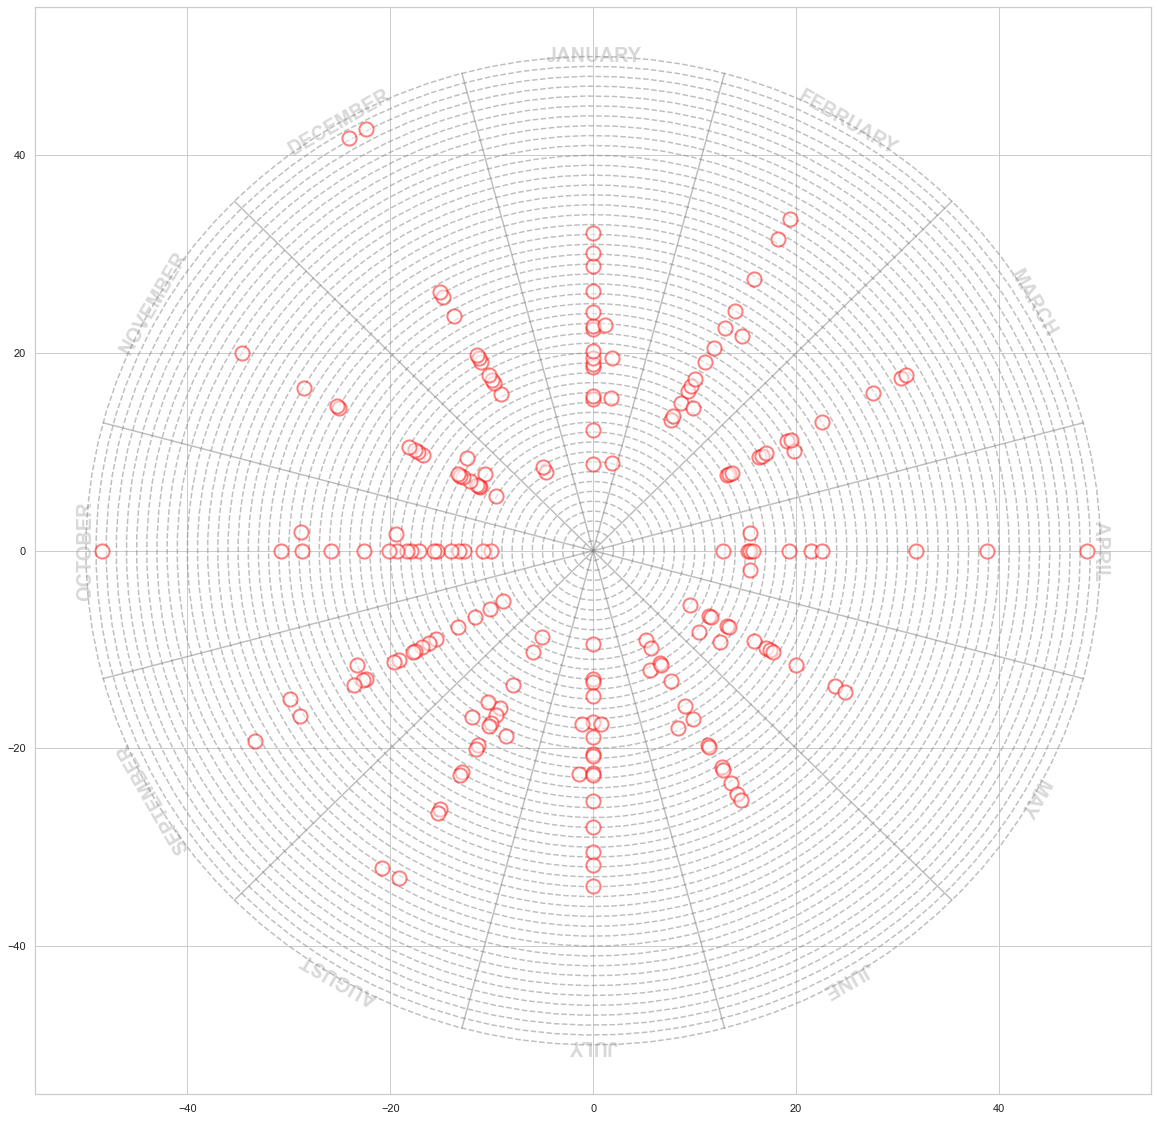

In [48]:
##### There are 12 months and a total angle of 2*pi to divide.

N_months = 12
totalAngle = 2.0 * np.pi
Angle = totalAngle / N_months
halfAngle = Angle / 2.0

##### Next comes the main plot

fig,ax = plt.subplots(figsize = (20,20))

##### We will create dashed circles ranging from 1 to the maximum number of kms run in a day for the entire year

Npts = np.linspace(0,2*np.pi,100)

maxDist = 50  #### Change this number according to real data

for i in range(1,maxDist + 1, ):
    ax.plot(
        i*np.cos(Npts),i*np.sin(Npts),'--',color="grey",alpha=0.5
    )
    

    
##### Next we will plot some radial lines that will demarcate the boundaries of the 12 sectors

for i in range(N_months):
    ax.plot(
        [0, maxDist*np.cos(Angle*(i+0.5))],     ##### The start and end x coordinate of the radial line
        [0, maxDist*np.sin(Angle*(i+0.5))],     ##### The start and end y coordinate of the radial line
        color="grey",
        alpha=0.5
    )

for i, month in enumerate(months):
    swarm = swarm_creator(month)
    x,y = extract_raw_coordinates_from_swarm(swarm)
    shifted_xy = add_offset(x,y)
    rotation_matrix = rotation(angle = i*Angle)
    rotated_xy = apply_rotation(rotation_matrix, shifted_xy)
    ax.scatter(
        rotated_xy[0],
        rotated_xy[1],
        s=200,
        c='w',
        ec='red',
        marker = "o",
        lw=2,
        zorder=5,
        alpha=0.5
    )


for i, month in enumerate(months):
    text_angle = np.degrees(Angle * i)  # Start the loop from index 0
    text_radius = maxDist

    ax.text(
        text_radius * np.cos(Angle * i),
        text_radius * np.sin(Angle * i),
        month.upper(),
        color="grey",
        ha='center',
        va='center',
        weight='black',
        rotation=text_angle - 90,  # Adjust the rotation angle
        rotation_mode='anchor',
        size=20,
        alpha=0.3
    )
    
    
    

    
    
plt.savefig("./running.jpeg", bbox_inches='tight', format='jpeg');

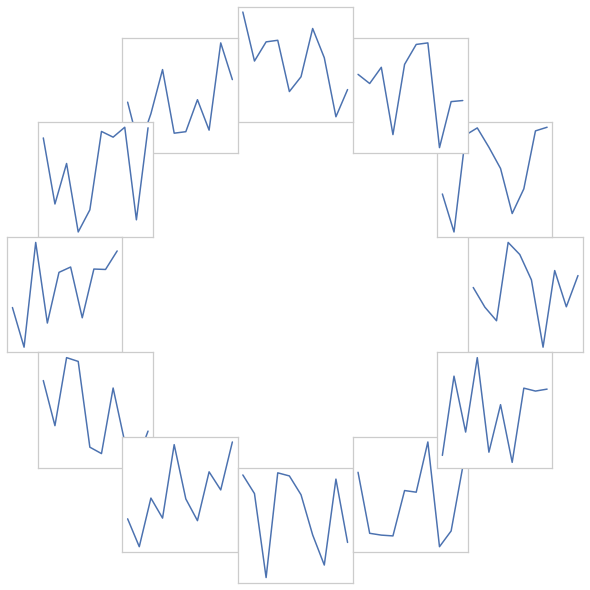

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure(figsize=(8, 8))

# Set the number of axes
num_axes = 12

# Calculate the positions of the axes around a circle
theta = np.linspace(0, 2 * np.pi, num_axes, endpoint=False)
radius = 0.4
positions = np.column_stack([0.5 + radius * np.cos(theta), 0.5 + radius * np.sin(theta), 0.2 * np.ones_like(theta), 0.2 * np.ones_like(theta)])

# Add 12 axes around the circle
for i in range(num_axes):
    ax = fig.add_axes(positions[i], )
    ax.set_xticks([])
    ax.set_yticks([])

    # Add your plot or content to each axis
    data = np.random.rand(10)  # Replace this with your actual data
    ax.plot(np.linspace(0, 2 * np.pi, 10), data)

# Display the plot
plt.show()


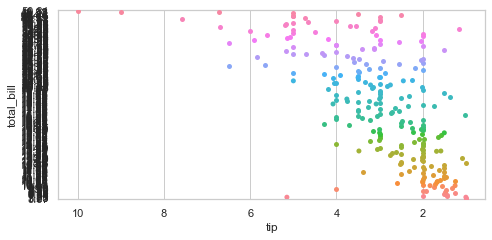

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.rcParams["figure.figsize"] = [7.00, 3.50]

# Create some sample data for the swarm plot
data = sns.load_dataset("tips")

# Create the swarm plot with rotated axes
ax = sns.swarmplot(x="tip", y="total_bill", data=data, orient="h")

# Rotate the entire plot
ax.set_xlim(ax.get_xlim()[::-1])  # Reverse the x-axis limits
ax.set_ylim(ax.get_ylim()[::-1])  # Reverse the y-axis limits

plt.show()
